In [3]:
%matplotlib inline
import numpy as np
import pyfits
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord, Distance
from astropy import units as u
import matplotlib.pyplot as plt

# Constants
ang_sep = 2.86  # max Angle of separation
H0 = 70.  # Hubble constant
c = 299792.458  # c [km/s]
rs_dif = 0.0016666  # Maximum z difference allowed for object within +/- 500 km/s

# set cosmology
cosmo = FlatLambdaCDM(H0=70., Om0=0.3) # cosmology

print ''
print 'done!'


done!


In [67]:
# read my data
path = '/Users/thbrown/AA_project/TOBY_STACKING/SAMPLES/FULL/masters/'
rfile = 'sample_master.fits'


hdulist = pyfits.open(path+rfile)
data = hdulist[1].data  # assuming the first extension is a table
cols = hdulist[1].columns

ID = np.array(data['ID'])
z = np.array(data['Z'])
ra = np.array(data['RA'])
dec = np.array(data['DEC'])

print type(ra)

print 'number of objects: ', len(ID)
print ''
print 'done!'

<type 'numpy.ndarray'>
number of objects:  30368

done!


In [4]:
# mock coordinates
N=1000
ra = ((237.5 - 112.5) * np.random.random_sample(N) + 112.5)
dec = (30 * np.random.random_sample(N))
z = (0.05-0.02) * np.random.random_sample(N) + 0.02

print 'done!'


done!


In [12]:
# Fixed Aperture brute force
ap_mpc = 1. # fixed Aperture (Mpc)

ID_TARGET_GALAXY = []
N = []
N_cos = []

# ra, dec, luminosity distance
rarad_arr = ra * np.pi/180
decrad_arr = dec * np.pi/180
lumdist_arr = cosmo.luminosity_distance(rs)

for i in range(len(ID)):

    successful_matches = []

    cnt = 1 # counts for area and volume densities
    cnt_cos = 1
    
    # object 1 ra, dec
    ra1rad = rarad_arr[i]
    dec1rad = decrad_arr[i]
    lumdist1 = lumdist_arr[i]            # luminosity distance to object 1

    
    for j in range(len(ID)):
        if j != i and abs(ra[j] - ra[i]) < ang_sep and \
            abs(dec[j] - dec[i]) < ang_sep and abs(rs[j]-rs[i]) < rs_dif:

            # object 2 ra, dec
            ra2rad = rarad_arr[j]
            dec2rad = decrad_arr[j]
            # luminosity distance to object 2
            lumdist2 = lumdist_arr[j]
#             print ID[i], ID[j]
#             print ra[i], dec[i]
#             print ra[j], dec[j]
#             print lumdist1, lumdist2
            

#                 # Determine Cartesian coordinates between two objects
#                 x1 = lumdist1*np.sin(dec1rad)*np.cos(ra1rad)
#                 x2 = lumdist2*np.sin(dec2rad)*np.cos(ra2rad)
#                 y1 = lumdist1*np.sin(ra1rad)*np.sin(dec1rad)
#                 y2 = lumdist2*np.sin(ra2rad)*np.sin(dec2rad)
#                 z1 = lumdist1*np.cos(dec1rad)
#                 z2 = lumdist2*np.cos(dec2rad)
            # distance between the two objects in 3D Cartesian-space 
#                 angsep_Mpc = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2) 

            ### haversines rule (ish) 
            #   ==> cos(theta) = sin(d1)sin(d2) + cos(d1)cos(d2)cos(ra1-ra2)
            cos_seprad = (np.sin(dec1rad)*np.sin(dec2rad)) + \
                            (np.cos(dec1rad)*np.cos(dec2rad)*np.cos(ra1rad-ra2rad))

            theta = np.arccos(cos_seprad) # angle of separation
#             print theta
            
            D_squared = lumdist1**2 + lumdist2**2 - (2 * lumdist1 * lumdist2 * cos_seprad) # law of cosines


            # alternate trig measures
            phi = theta / 2.
            angsep_Mpc = 2 * lumdist1 * np.sin(phi) # same distance from approx.
#           tb_mod_angsep_Mpc_1 = (lumdist1 * np.sin(phi)) + (lumdist2 * np.sin(phi)) # two ra triangles

    
#             print re_angsep_Mpc, np.sqrt(D_squared)
#             print re_angsep_Mpc, tb_mod_angsep_Mpc_1, np.sqrt(D_squared)
            # Number with separation distance < app_mpc
#             print np.sqrt(D_squared), app_mpc
            if np.sqrt(D_squared) <= ap_mpc:
                cnt_cos = cnt_cos + 1
            if angsep_Mpc <= ap_mpc:
                cnt = cnt + 1

    N.append(cnt)
    N_cos.append(cnt_cos)

NameError: name 'rs' is not defined

In [68]:
# # Fixed aperture K-D tree method
# # This creates the catalog and deals with coordinates
# # and cosmology (through Distance)
# ap_mpc = 1. #* u.Mpc # fixed Aperture (Mpc)
# c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, distance=Distance(z=z, cosmology=cosmo))

# fa_dist = []
# fa_cnt = []


# for i in range(1,20):
#     # match the catalog onto itself and give the i-th nearest
#     # the 0-th is not possible, the 1st gives the galaxy itself.
#     # d3d contains the 3d distances.
#     idx, d2d, d3d = c.match_to_catalog_3d(c,i) # or 5 or 10
#     fa_dist.append(d3d)
    
#     fa_n = fa_dist[np.where(fa_dist >= 1)]

In [72]:
# Fixed aperture K-D tree method
# This creates the catalog and deals with coordinates
# and cosmology (through Distance)
ap_mpc = 1. #* u.Mpc # fixed Aperture (Mpc)
c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, distance=Distance(z=z, cosmology=cosmo))

fa_dist = []
fa_cnt = []

idx1,idx2, d2d, d3d = c.search_around_3d(c, 1*u.Mpc)  

for i in range(0, len(ra)):
    fa_cnt.append(len(idx1[idx1 == i]))

    
print d3d[idx1 == 4]
print len(idx1)
print len(idx2)
print idx1[0:9]
print idx2[0:9]
print d3d[0:9]

print 'done'

[ 0.52994245  0.          0.63037218] Mpc
57052
57052
[0 1 2 3 4 4 4 5 5]
[  0   1   2   3  91   4 137  82   5]
[ 0.          0.          0.          0.          0.52994245  0.
  0.63037218  0.71535677  0.        ] Mpc
done


In [80]:
print (fa_cnt[0:10])


[1, 1, 1, 1, 3, 2, 1, 1, 1, 1]


In [45]:
print np.shape(fa_dist)
fa_dist = np.array(fa_dist)


print np.shape(fa_dist[np.where(fa_dist <1)])
die

# this is just to convert a list of Quantity arrays to
# a 2D Quantity array
nn_dist = u.Quantity(nn_dist)

# distances to the nearest 3 neighbors for galaxy at index 2
# nn_dist[:3,2]

# in general [:neighbors,gal_id]
# to get the same result as you ipynb we need to transpose.
neigh3 = nn_dist[:3].T
neigh5 = nn_dist[:5].T
neigh7 = nn_dist[:7].T
neigh10 = nn_dist[:10].T

print 'done'

(19, 30368)
(57052,)


NameError: name 'die' is not defined

In [2]:
# N_Mpc2 = N_area / (np.pi**app_mpc**2) # Number per unit area
N_Mpc2 = [n / (np.pi*(app_mpc**2)) for n in N]
N_Mpc2_cos = [n / (np.pi*(app_mpc**2)) for n in N_cos]

# N_Mpc3 = N_volume  / ((4/3)*np.pi**app_mpc**3) # Number per unit volume
N_Mpc3 = [n / ((4. / 3.)*np.pi*(app_mpc**3)) for n in N] 
N_Mpc3_cos = [n / ((4. / 3.)*np.pi*(app_mpc**3)) for n in N_cos] 

print ''
print 'done!'


done!


In [19]:
wdir = '/Users/thbrown/AA_project/TOBY_STACKING/SAMPLES/FULL/ENVIRONMENT/'
wfile = "local_density.fits"

print len(N_Mpc3)


col1 = pyfits.Column(name='ID_match', format='J', array=ID)
col2 = pyfits.Column(name='N', format='I', array=N)
col3 = pyfits.Column(name='ld_Mpc2', format='D', array=N_Mpc2)
col4 = pyfits.Column(name='ld_Mpc3', format='D', array=N_Mpc3)
col5 = pyfits.Column(name='ld_cos', format='I', array=N_cos)
col6 = pyfits.Column(name='ld_Mpc2_cos', format='D', array=N_Mpc2_cos)
col7 = pyfits.Column(name='ld_Mpc3_cos', format='D', array=N_Mpc3_cos)


cols = pyfits.ColDefs([col1, col2, col3, col4, col5, col6, col7])


tbhdu_new = pyfits.new_table(cols)
tbhdu_new.writeto(wdir+wfile, clobber=True) # write to file, overwrite=True

print ''
print 'fits file writen to ' + wfile

13278
Overwriting existing file '/Users/thbrown/AA_project/TOBY_STACKING/SAMPLES/FULL/ENVIRONMENT/local_density.fits'.

fits file writen to local_density.fits


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# N_Mpc2 = N_area / (np.pi**app_mpc**2) # Number per unit area
N_Mpc2 = [n / (np.pi*(1**2)) for n in N]
N_Mpc2_cos = [n / (np.pi*(1**2)) for n in N_cos]

# N_Mpc3 = N_volume  / ((4/3)*np.pi**app_mpc**3) # Number per unit volume
N_Mpc3 = [n / ((4. / 3.)*np.pi*(1**3)) for n in N] 
N_Mpc3_cos = [n / ((4. / 3.)*np.pi*(1**3)) for n in N_cos] 

print np.log10(min(N_Mpc3))

NameError: name 'distance' is not defined

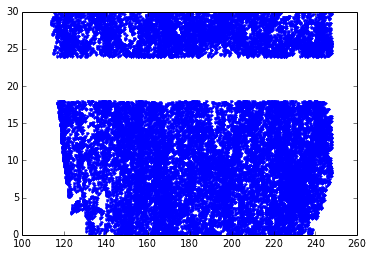

In [77]:
plt.figure()

plt.plot(ra, dec, '.')

plt.figure()

n, bins, patches = plt.hist(distance, 30,edgecolor='r', linewidth=5, facecolor='r', alpha=0.75)
# n, bins, patches = plt.hist(N_Mpc3, 30,edgecolor='b', linewidth=5, facecolor='none', alpha=0.75)


plt.figure()
# n, bins, patches = plt.hist(N, 6,edgecolor='r', linewidth=5, facecolor='r', alpha=0.75)
# n, bins, patches = plt.hist(N_Mpc2, 6,edgecolor='g', linewidth=5, facecolor='g', alpha=0.75)
# n2, bins, patches = plt.hist(N_Mpc2_cos, 6, edgecolor='b', linewidth=5, facecolor='none', alpha=0.75)

plt.show()

In [28]:
N = np.array(N)
N_Mpc2 = np.array(N_Mpc2)
N_Mpc3 = np.array(N_Mpc3)

idx = N[np.where(N >= 1)]

print 4./3.

print N[idx[0:10]]

print N_Mpc2[idx[0:10]]
print N_Mpc3[idx[0:10]]

1.33333333333
[0 0 0 0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
